In [ ]:
%matplotlib widget
%reload_ext autoreload
from Observation import *
from matplotlib.colors import LogNorm
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import Layout, HBox, VBox, interactive_output


def load_instruments(sheet_id= "1Ox0uxEm2TfgzYA6ivkTpU4xrmN5vO5kmnUPdCSt73uU", sheet_name= "instruments.csv", database="Online DB"):
    """
    Load instruments data from a Google Sheet or local database.

    Parameters:
    - sheet_id (str): The Google Sheet ID.
    - sheet_name (str): The name of the sheet to load.
    - database (str): Either "Online DB" or "Local DB".

    Returns:
    - instruments (Table): The loaded instruments data.
    - database (str): The database source used.
    """
    url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
    if database == "Online DB":
        try:
            instruments =   Table.from_pandas(pd.read_csv(url)).filled(np.nan)
            database = "Online DB"
        except Exception as e:
            print(e)
            instruments = Table.from_pandas(pd.read_excel("../instruments.xlsx"))
            instruments = instruments[instruments.colnames]
            for col_name in instruments.colnames[3:]:
                instruments[col_name] = to_float_or_nan(instruments[col_name])
            database = "Local DB"
    else:
        instruments = Table.from_pandas(pd.read_excel("../instruments.xlsx"))
        instruments = instruments[instruments.colnames]
        for col_name in instruments.colnames[3:]:
            instruments[col_name] = to_float_or_nan(instruments[col_name])
        database = "Local DB"
    return instruments, database

instruments, database = load_instruments()






instrument_list = instruments.colnames[3:]
output_params = ["SNR", "point_source_5s", "SB_lim_per_pix"]
variable_options = [
    "------DETECTOR PERFORMANCE", "QE", "RN", "Dark_current", "cosmic_ray_loss_per_sec", "EM_gain", "extra_background", "CIC_charge",
    "-------------OBSERVED SOURCE", "Signal", "Sky", "Size_source", "Line_width",
    "--------OBSERVATION STRATEGY", "Atmosphere", "exposure_time", "acquisition_time", "readout_time", "lambda_stack", "wavelength",
    "-----------INSTRUMENT DESIGN", "Collecting_area", "pixel_scale", "Throughput", "PSF_RMS_mask", "PSF_RMS_det",
    "---------SPECTROGRAPH DESIGN", "Spectral_resolution", "Slitwidth", "Slitlength", "dispersion"
]


# Fonction utilitaire
def make_param_row(default_val,min_, max_, n):
    # print(min_, max_)
    p = widgets.Dropdown(options=variable_options, value=default_val, layout=Layout(width='250px'))
    min_ = widgets.FloatText(value=min_, layout=Layout(width='150px'), description="Min:")
    max_ = widgets.FloatText(value=max_, layout=Layout(width='150px'), description="Max:")
    n = widgets.FloatText(value=n, layout=Layout(width='130px'), description="N:")
    return p, min_, max_, n



def update_plot(instrument, output, x_param, x_min, x_max,xn, y_param, y_min, y_max, yn,z_param, z_min, z_max,zn):
    import matplotlib.pyplot as plt
    import numpy as np

    x_vals = np.linspace(x_min, x_max, int(float(xn)))
    y_vals = np.linspace(y_min, y_max, int(yn))
    z_vals = np.linspace(z_min, z_max, int(zn))

    fig, axes = plt.subplots(int(zn/2+zn%2),2,  figsize=(13, 8), sharex=True, sharey=True, layout='compressed')
    axes = axes.flatten()

    kwargs = {a: b for a, b in zip(instruments["Charact."][:40], instruments["SCWI"][:40])}
    for c in ["Spectro description", "dimensions", "FOV_size", "Bandpass", "Mode", "Name", "Detector_type", 'Altitude', 'Full_well', 'conversion_gain']:
        kwargs.pop(c, None)
    # print(kwargs["Throughput"])

    for idx, z in enumerate(z_vals):
        Z = np.zeros((len(y_vals), len(x_vals)))
        for j, y in enumerate(y_vals):
            for i, x in enumerate(x_vals):
                param_kwargs ={}# kwargs.copy()  # copie propre
                param_kwargs[x_param] = x
                param_kwargs[y_param] = y
                param_kwargs[z_param] = z
                # param_kwargs["dispersion"] = 2000 / param_kwargs["Spectral_resolution"] / 2
                # print(param_kwargs["dispersion"],  param_kwargs["Spectral_resolution"])
                obs = Observation(instruments=instruments, instrument=instrument, IFS=True, test=False, **param_kwargs)
                Z[j, i] = getattr(obs, output)[0]
        ax = axes[idx]
        dx = (x_max - x_min) / Z.shape[1]
        dy = (y_max - y_min) / Z.shape[0]

        extent = [x_min - dx/2, x_max + dx/2, y_min - dy/2, y_max + dy/2]
        im = ax.imshow(Z, origin='lower', extent=extent, aspect='auto', cmap='viridis')
        ax.set_title(f"{z_param} = {z:.2f}")

        # Xlabel uniquement sur la dernière ligne
        if idx >= 2:
            ax.set_xlabel(x_param)
        else:
            ax.set_xlabel("")

        # Ylabel uniquement sur la première colonne
        if idx % 2 == 0:
            ax.set_ylabel(y_param)
        else:
            ax.set_ylabel("")

        # Calcul des centres pour placer les valeurs au centre des pixels
        dx = (x_max - x_min) / Z.shape[1]
        dy = (y_max - y_min) / Z.shape[0]
        x_centers = x_min + dx / 2 + np.arange(Z.shape[1]) * dx
        y_centers = y_min + dy / 2 + np.arange(Z.shape[0]) * dy

        # for j, y in enumerate(y_centers):
        #     for i, x in enumerate(x_centers):
        #         ax.text(x, y, f"{Z[j, i]:.1E}", ha='center', va='center', fontsize=8)
        for (j, i), val in np.ndenumerate(Z):
            ax.text(x_vals[i], y_vals[j], f"{val:.1E}", ha='center', va='center', fontsize=8)
        # Ajouter une colorbar individuelle pour chaque subplot
        cbar = fig.colorbar(im, ax=ax, shrink=0.8)
        cbar.set_label(output)

    # fig.suptitle(f"{instrument} : {param_kwargs["Throughput"]} : {output} vs {x_param} & {y_param} at various {z_param}", fontsize=14)
    fig.suptitle(f"{instrument} : {output} vs {x_param} & {y_param} at various {z_param}", fontsize=14)
    plt.show()
def update_plot2(instrument, output, x_param, x_min, x_max,xn, y_param, y_min, y_max, yn,z_param, z_min, z_max,zn):
    import matplotlib.pyplot as plt
    import numpy as np

    x_vals = np.linspace(x_min, x_max, int(float(xn)))
    y_vals = np.linspace(y_min, y_max, int(float(yn)))
    z_vals = np.linspace(z_min, z_max, int(float(zn)))

    fig, axes = plt.subplots(int(zn/2+zn%2),2, figsize=(13, 8), sharex=True, sharey=True, layout='compressed')
    axes = axes.flatten()

    kwargs = {a: b for a, b in zip(instruments["Charact."][:40], instruments["SCWI"][:40])}
    for c in ["Spectro description", "dimensions", "FOV_size", "Bandpass", "Mode", "Name", "Detector_type", 'Altitude', 'Full_well', 'conversion_gain']:
        kwargs.pop(c, None)

    for idx, z in enumerate(z_vals):
        ax = axes[idx]
        curves = []
        for y in y_vals:
            curve = []
            for x in x_vals:
                param_kwargs = {}  # kwargs.copy()
                param_kwargs[x_param] = x
                param_kwargs[y_param] = y
                param_kwargs[z_param] = z
                # param_kwargs["dispersion"] = 2000 / param_kwargs["Spectral_resolution"] / 2

                obs = Observation(instruments=instruments, instrument=instrument, IFS=True, test=False, **param_kwargs)
                curve.append(getattr(obs, output)[0])
            curves.append(curve)

        curves = np.array(curves)  # shape (len(y_vals), len(x_vals))

        # Tracés
        for j, y in enumerate(y_vals):
            ax.plot(x_vals, curves[j], label=f"{y_param}={y:.2f}", lw=2)
            # Zone d'incertitude (ici fictive : ±10%)
            lower = 0.9 * np.array(curves[j])
            upper = 1.1 * np.array(curves[j])
            ax.fill_between(x_vals, lower, upper, alpha=0.3)

        if idx >= 2:
            ax.set_xlabel(x_param)
        if idx % 2 == 0:
            ax.set_ylabel(output)
        ax.set_title(f"{z_param} = {z:.2f}")
        ax.grid(True)
        ax.legend(fontsize=8)

    fig.suptitle(f"{instrument} : {output} vs {x_param} (various {y_param}) at different {z_param}", fontsize=14)
    plt.show()


from ipywidgets import Checkbox

def dispatch_plot(use_imshow, instrument, output,
                  x_param, x_min, x_max,xn,
                  y_param, y_min, y_max,yn,
                  z_param, z_min, z_max,zn):
    if use_imshow:
        update_plot(instrument, output,
                  x_param, x_min, x_max,xn,
                  y_param, y_min, y_max,yn,
                  z_param, z_min, z_max,zn)
    else:
        update_plot2(instrument, output,
                  x_param, x_min, x_max,xn,
                  y_param, y_min, y_max,yn,
                  z_param, z_min, z_max,zn)

def show_evolution(instrument="SCWI SPEC", output="SNR",
                   param1=["Spectral_resolution", 500, 2000,6],
                   param2=["Line_width", 2, 5, 6],
                   param3=["pixel_scale", 1, 2,4],imshow=True):

    instrument_dropdown = widgets.Dropdown(options=instrument_list, description="Instrument:", layout=Layout(width='250px'))
    output_dropdown = widgets.Dropdown(options=output_params, value=output, description="Output:", layout=Layout(width='250px'))

    # Paramètres X, Y, Z
    x_param, x_min, x_max, xn = make_param_row(*param1)
    y_param, y_min, y_max, yn = make_param_row(*param2)
    z_param, z_min, z_max, zn = make_param_row(*param3)

    # Checkbox pour choisir le type de plot
    imshow_checkbox = Checkbox(value=imshow, description='imshow/plot', indent=False)

    # Organisation en 5 lignes
    ui = VBox([
        HBox([instrument_dropdown, output_dropdown]),
        HBox([x_param, x_min, x_max,xn]),
        HBox([y_param, y_min, y_max,yn]),
        HBox([z_param, z_min, z_max,zn]),
        imshow_checkbox,
    ])

    # Affichage dynamique selon la checkbox
    out = interactive_output(dispatch_plot, {
        "use_imshow": imshow_checkbox,
        "instrument": instrument_dropdown,
        "output": output_dropdown,
        "x_param": x_param, "x_min": x_min, "x_max": x_max, "xn": xn,
        "y_param": y_param, "y_min": y_min, "y_max": y_max, "yn": yn,
        "z_param": z_param, "z_min": z_min, "z_max": z_max, "zn": zn,
    })

    display(ui, out)

    
show_evolution()

Output()

Output()

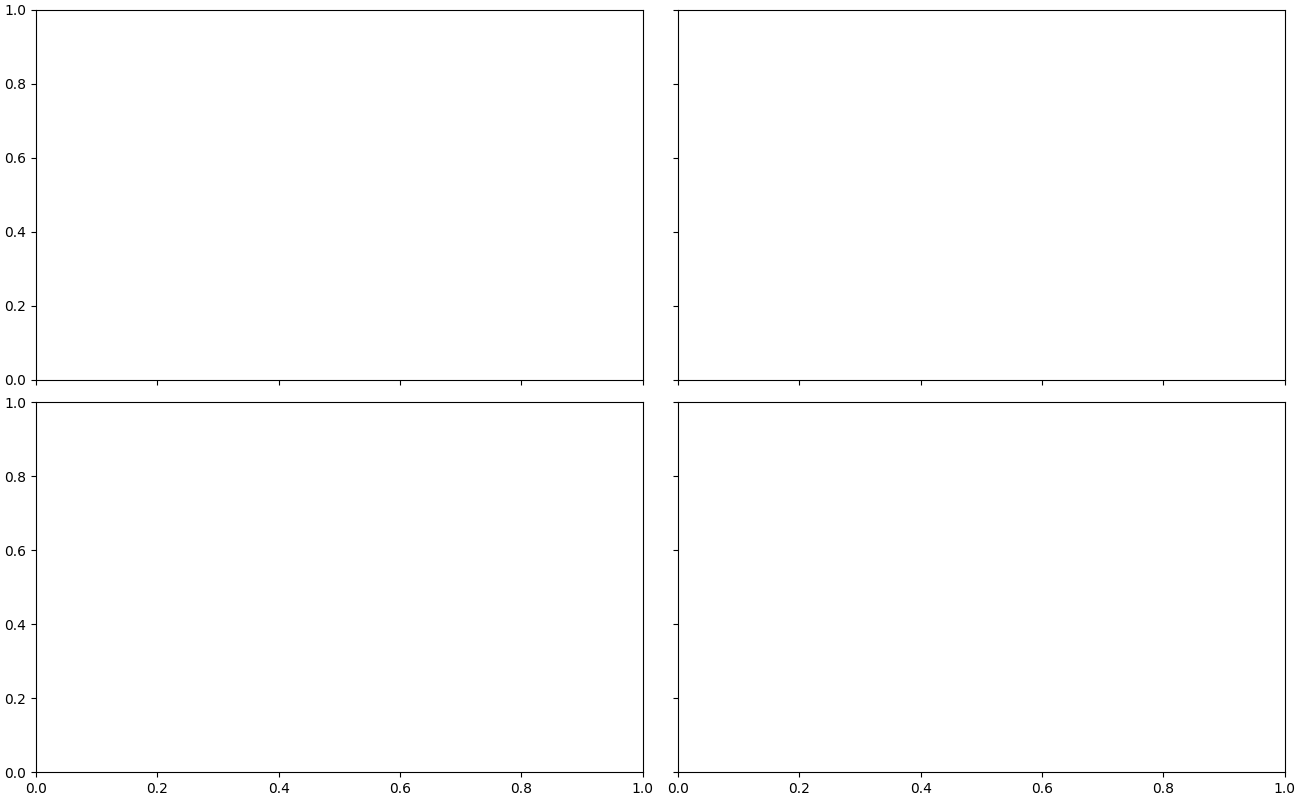

In [16]:
show_evolution(instrument="SCWI SPEC", output="SNR",
                   param1=["Spectral_resolution", 500, 2000,6],
                   param2=["Line_width", 2, 5, 2],
                   param3=["pixel_scale", 1, 2,4],imshow=False)

In [30]:
6%2

0

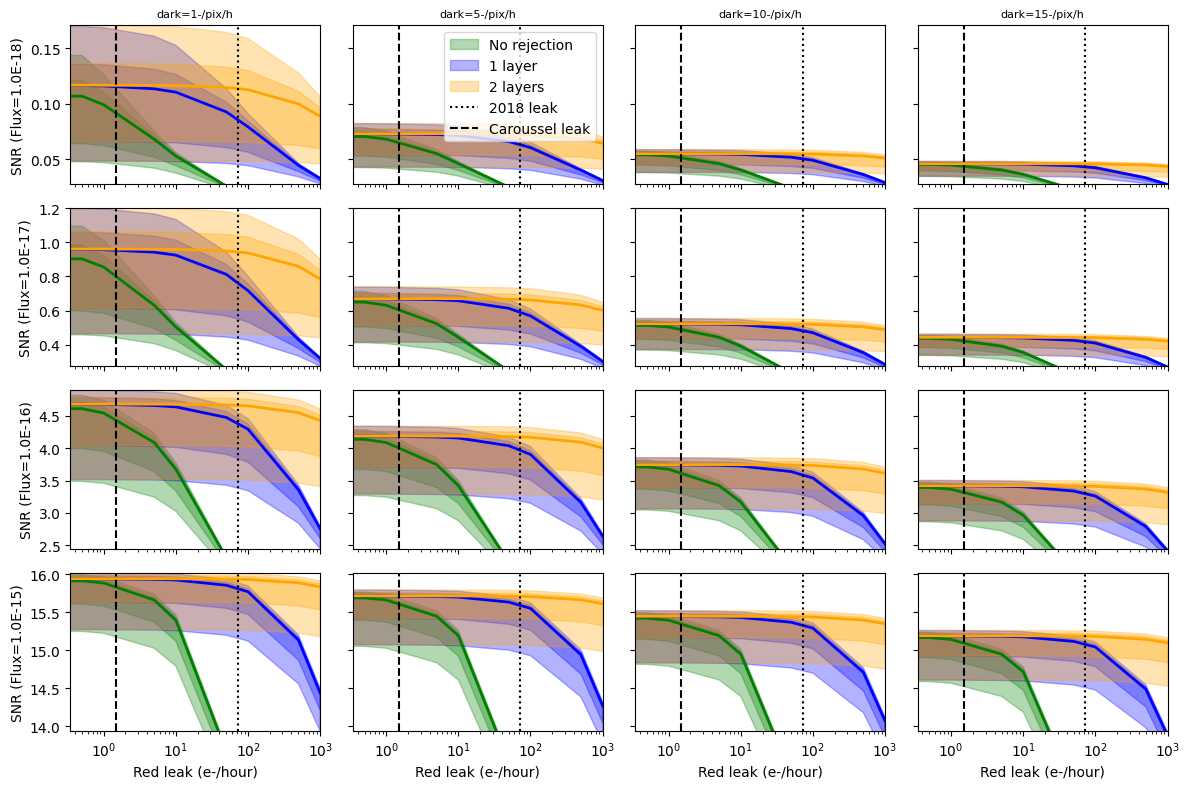

In [ ]:

estimator = "SNR"
# estimator = "time2reach_n_sigma_SNR"
Signals = [1e-18,1e-17,1e-16,1e-15]
Darks = [1,5,10,15]
fig, axes = plt.subplots(len(Signals),len(Darks),sharex=True,figsize=(12,8),sharey="row")
for n, Signal in enumerate(Signals):
    for m, Dark in enumerate(Darks):
        for j, sky in enumerate(skys):
            for i, extra in enumerate(extras):
                no[j,i] = np.unique(getattr(Observation(instruments=instruments,instrument="SCWI SPEC",IFS=True,Signal=Signal,Sky=sky, Dark_current=Dark,extra_background=extra, QE=0.48,i=20,counting_mode=counting_mode),estimator))
                l0[j,i] = np.unique(getattr(Observation(instruments=instruments,instrument="SCWI SPEC",IFS=True,Signal=Signal,Sky=sky, Dark_current=Dark, extra_background=extra, QE=0.73,i=20,counting_mode=counting_mode),estimator))
                l1[j,i] = np.unique(getattr(Observation(instruments=instruments,instrument="SCWI SPEC",IFS=True,Signal=Signal,Sky=sky,  Dark_current=Dark, extra_background=extra/33, QE=0.73,i=20,counting_mode=counting_mode),estimator))
                l2[j,i] = np.unique(getattr(Observation(instruments=instruments,instrument="SCWI SPEC",IFS=True,Signal=Signal,Sky=sky,  Dark_current=Dark, extra_background=extra/33/16, QE=0.73,i=20,counting_mode=counting_mode),estimator))


        axes[n,m].fill_between(extras,l0[0,:],l0[-1,:],alpha=0.3,color="green",label="No rejection",interpolate=True)
        axes[n,m].fill_between(extras,l0[2,:],l0[-2,:],alpha=0.3,color="green",interpolate=True)
        axes[n,m].plot(extras,l0[3,:],color="green",lw=2)
        axes[n,m].fill_between(extras,l1[0,:],l1[-1,:],alpha=0.3,color="blue",label="1 layer",interpolate=True)
        axes[n,m].fill_between(extras,l1[2,:],l1[-2,:],alpha=0.3,color="blue",interpolate=True)
        axes[n,m].plot(extras,l1[3,:],color="blue",lw=2)
        axes[n,m].fill_between(extras,l2[0,:],l2[-1,:],alpha=0.3,color="orange",interpolate=True,label="2 layers")
        axes[n,m].fill_between(extras,l2[2,:],l2[-2,:],alpha=0.3,color="orange",interpolate=True)
        axes[n,m].plot(extras,l2[3,:],color="orange",lw=2)
        axes[n,m].axvline(72,ls=":",c="k",label="2018 leak")
        axes[n,m].axvline(1.5,ls="--",c="k",label="Caroussel leak")
            # plt.yscale("log")
        if estimator == "time2reach_n_sigma_SNR":
            axes[n,0].set_ylabel("H for 5σ detect (F=%0.0E)"%(Signal))
        else:
            # axes[n,-1].twinx().set_ylabel("SNR (Flux=%0.1E)"%(Signal))
            axes[n,0].set_ylabel("SNR (Flux=%0.1E)"%(Signal))

        axes[-1,m].set_xlabel("Red leak (e-/hour)")
        axes[0,m].set_title("dark=%i-/pix/h"%(Dark),fontsize=8)
        if m==0:
            axes[n,0].set_ylim((np.min(l1),np.max(l0)))
            if estimator == "time2reach_n_sigma_SNR":
                axes[n,0].set_yscale("log")
                axes[n,0].set_ylim((np.min(l0),np.max(l1)))
axes[0,0].set_xscale("log")
axes[0,1].legend(fontsize=10)
axes[0,0].set_xlim((np.min(extras),np.max(extras)))
fig.tight_layout()
plt.show()
# plt.fill_between()

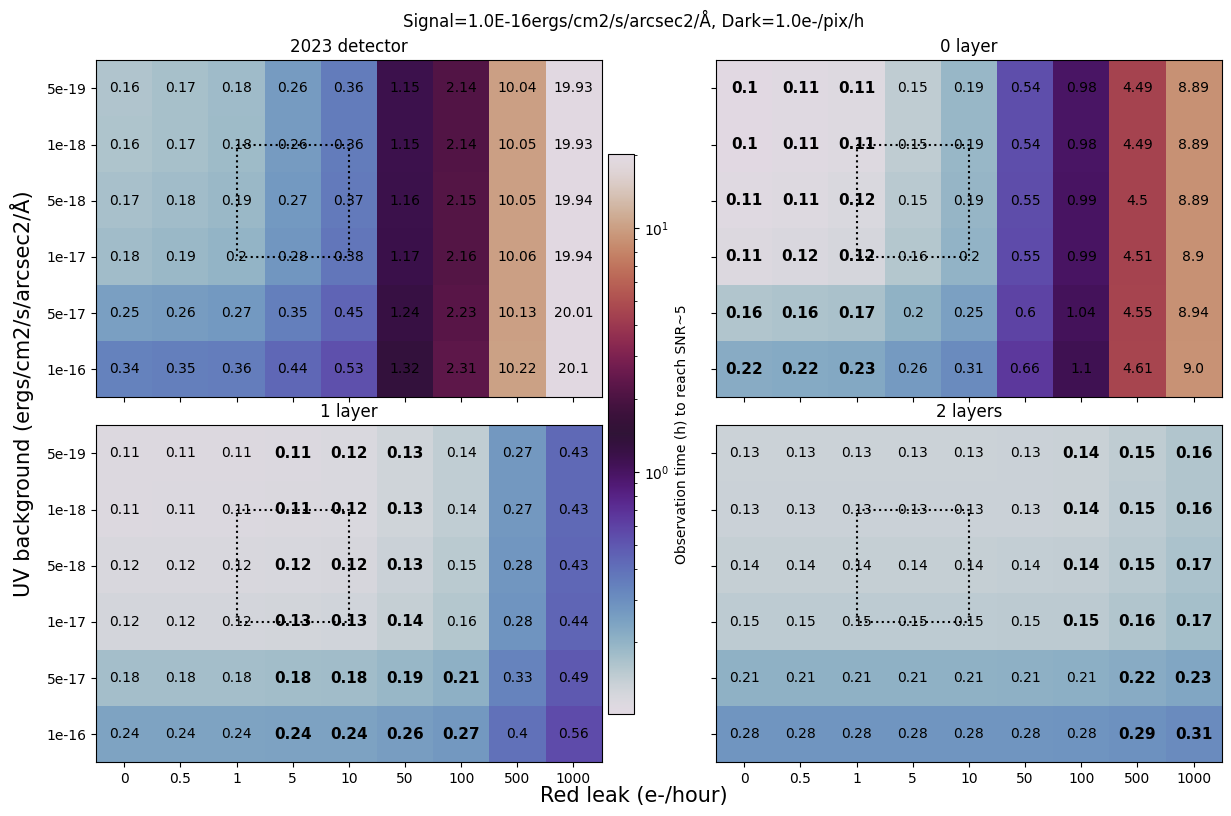

In [ ]:

from Observation import *




skys = [5e-19,1e-18,5e-18, 1e-17,5e-17, 1e-16]
# skys = [1e-18,1e-17,1e-16]
extras = [0.5,2,7,22]
extras = [0,0.5,1,5,10,50,100,500,1000]#,100,500]

no = np.zeros((len(extras),len(skys))).T
l0 = np.zeros((len(extras),len(skys))).T
l1 = np.zeros((len(extras),len(skys))).T
l2 = np.zeros((len(extras),len(skys))).T


# sys.path.append("/Users/Vincent/Github/fireball2-etc")
# sys.path.append("/Users/Vincent/Github/fireball2-etc/notebooks")
# sys.path.append("/Users/Vincent/Github/fireball2-etc/notebooks/interpolate")

skyms = [skys.index(1e-18),skys.index(1e-17)]
leaks = [extras.index(1),extras.index(10)]
Dark=1
Signal=1e-16
counting_mode=True
acquisition_time = 5
# for Signal in [1e-17,1e-16,1e-15][:3]:
for Dark in [1,5,10][:1]:
    for j, sky in enumerate(skys):
        for i, extra in enumerate(extras):
            no[j,i] = np.unique(Observation(Signal=Signal,Sky=sky, acquisition_time=1,Dark_current=Dark,extra_background=extra, QE=0.48,i=20,counting_mode=counting_mode).time2reach_n_sigma_SNR)
            l0[j,i] = np.unique(Observation(Signal=Signal,Sky=sky, acquisition_time=1,Dark_current=Dark, extra_background=extra, QE=0.72,i=20,counting_mode=counting_mode).time2reach_n_sigma_SNR)
            l1[j,i] = np.unique(Observation(Signal=Signal,Sky=sky,  acquisition_time=1,Dark_current=Dark, extra_background=extra/33, QE=0.66,i=20,counting_mode=counting_mode).time2reach_n_sigma_SNR)
            l2[j,i] = np.unique(Observation(Signal=Signal,Sky=sky,  acquisition_time=1,Dark_current=Dark, extra_background=extra/33/16, QE=0.57,i=20,counting_mode=counting_mode).time2reach_n_sigma_SNR)

    fig, axes = plt.subplots(2,2,sharex=True, sharey=True,figsize=(13,8))
    fig.subplots_adjust(right=0.8)
    for ax, a,n in zip(axes.flatten(), [no,l0,l1,l2],["2023 detector","0 layer","1 layer","2 layers"]) :
        im = ax.imshow(a, norm=LogNorm(vmin=np.min([no,l0,l1,l2]), vmax=np.max([no,l0,l1,l2])),cmap='twilight' )
        for (j,i),label in np.ndenumerate(a):
            if label==np.min([no[j,i],l0[j,i],l1[j,i],l2[j,i]]):
                ax.text(i,j,np.round(label,2),ha='center',va='center', weight='bold',fontsize=11)
            else:
                ax.text(i,j,np.round(label,2),ha='center',va='center')
        ax.plot([leaks[0],leaks[1],leaks[1],leaks[0],leaks[0]],[skyms[0],skyms[0],skyms[1],skyms[1],skyms[0]],":k")
        ax.set_title(n)
        ax.set_xticklabels([0] + extras)
        ax.set_yticklabels([0] + skys)
    cbar_ax = fig.add_axes([0.48, 0.1, 0.02, 0.7])
    fig.suptitle("Signal=%0.1Eergs/cm2/s/arcsec2/Å, Dark=%0.1fe-/pix/h"%(Signal,Dark))
    fig.colorbar(im, cax=cbar_ax,label="Observation time (h) to reach SNR~5")
    fig.tight_layout()
    fig.text(0.5, -0.01,'Red leak (e-/hour)', ha='center',fontsize=15)
    fig.text(0.02, 0.5, 'UV background (ergs/cm2/s/arcsec2/Å)', va='center', rotation='vertical',fontsize=15)

    plt.show()

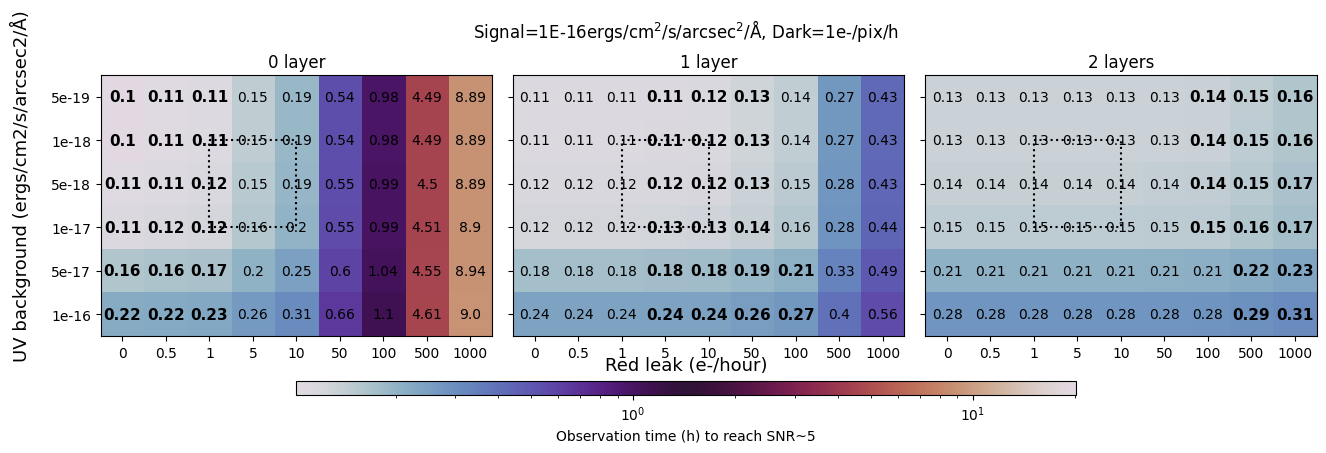

In [ ]:

from Observation import *
from matplotlib.colors import LogNorm

skys = [5e-19,1e-18,5e-18, 1e-17,5e-17, 1e-16]
# skys = [1e-18,1e-17,1e-16]
extras = [0.5,2,7,22]
extras = [0,0.5,1,5,10,50,100,500,1000]#,100,500]

no = np.zeros((len(extras),len(skys))).T
l0 = np.zeros((len(extras),len(skys))).T
l1 = np.zeros((len(extras),len(skys))).T
l2 = np.zeros((len(extras),len(skys))).T


# sys.path.append("/Users/Vincent/Github/fireball2-etc")
# sys.path.append("/Users/Vincent/Github/fireball2-etc/notebooks")
# sys.path.append("/Users/Vincent/Github/fireball2-etc/notebooks/interpolate")

skyms = [skys.index(1e-18),skys.index(1e-17)]
leaks = [extras.index(1),extras.index(10)]
Dark=1
Signal=1e-16
counting_mode=True
acquisition_time = 5
# for Signal in [1e-17,1e-16,1e-15][:3]:
for Dark in [1,5,10][:1]:
    for j, sky in enumerate(skys):
        for i, extra in enumerate(extras):
            no[j,i] = np.unique(Observation(Signal=Signal,Sky=sky, acquisition_time=1,Dark_current=Dark,extra_background=extra, QE=0.48,i=20,counting_mode=counting_mode).time2reach_n_sigma_SNR)
            l0[j,i] = np.unique(Observation(Signal=Signal,Sky=sky, acquisition_time=1,Dark_current=Dark, extra_background=extra, QE=0.72,i=20,counting_mode=counting_mode).time2reach_n_sigma_SNR)
            l1[j,i] = np.unique(Observation(Signal=Signal,Sky=sky,  acquisition_time=1,Dark_current=Dark, extra_background=extra/33, QE=0.66,i=20,counting_mode=counting_mode).time2reach_n_sigma_SNR)
            l2[j,i] = np.unique(Observation(Signal=Signal,Sky=sky,  acquisition_time=1,Dark_current=Dark, extra_background=extra/33/16, QE=0.57,i=20,counting_mode=counting_mode).time2reach_n_sigma_SNR)

    fig, axes = plt.subplots(1,3,sharex=True, sharey=True,figsize=(13,3.5))
    fig.subplots_adjust(right=0.8)
    for ax, a,n in zip(axes.flatten(), [l0,l1,l2],["0 layer","1 layer","2 layers"]) :
        im = ax.imshow(a, norm=LogNorm(vmin=np.min([no,l0,l1,l2]), vmax=np.max([no,l0,l1,l2])),cmap='twilight' )
        for (j,i),label in np.ndenumerate(a):
            if label==np.min([no[j,i],l0[j,i],l1[j,i],l2[j,i]]):
                ax.text(i,j,np.round(label,2),ha='center',va='center', weight='bold',fontsize=11)
            else:
                ax.text(i,j,np.round(label,2),ha='center',va='center')
        ax.plot([leaks[0],leaks[1],leaks[1],leaks[0],leaks[0]],[skyms[0],skyms[0],skyms[1],skyms[1],skyms[0]],":k")
        ax.set_title(n)
        ax.set_xticklabels([0] + extras)
        ax.set_yticklabels([0] + skys)
    cbar_ax = fig.add_axes([0.2, -0.1, 0.6, 0.04])
    fig.suptitle(r"Signal=%0.0Eergs/cm$^2$/s/arcsec$^2$/Å, Dark=%ie-/pix/h"%(Signal,Dark))
    fig.colorbar(im, cax=cbar_ax,label="Observation time (h) to reach SNR~5",orientation="horizontal")
    fig.tight_layout()
    fig.text(0.5, -0.03,'Red leak (e-/hour)', ha='center',fontsize=13)
    fig.text(-0.02, 0.5, 'UV background (ergs/cm2/s/arcsec2/Å)', va='center', rotation='vertical',fontsize=13)

    plt.show()